# ta-lib-006 ( Feature‑Engineering + Sequence Models)
https://chatgpt.com/c/680b5d6e-3f64-800a-9f2b-c08e35b0d0e8
What's new:

1- Change logic from classification to regression.

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import talib
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# Ensure plots inline
%matplotlib inline

In [4]:
# Parameters
DATA_PATH = "../datasets/XAGUSD-H1-rates.csv"   # Path to your downloaded MT5 CSV
SEQUENCE_LENGTH = 30                # Number of past candles per sample
PREDICT_HORIZON  = 5                # How many candles ahead to detect a trend change
TEST_SIZE = 0.2
RANDOM_STATE = 42
BATCH_SIZE = 64
EPOCHS = 50

In [5]:
# Load & Inspect Data
df = pd.read_csv(DATA_PATH, sep='\t')

In [6]:
# Combine <DATE> and <TIME> into single datetime index
df['DATETIME'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df.set_index('DATETIME', inplace=True)
df.drop(columns=['<DATE>', '<TIME>'], inplace=True)
df.head()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
DATETIME,,,,,,,
2015-01-02 09:00:00,15.889,15.896,15.807,15.834,993,18451000,21
2015-01-02 10:00:00,15.836,15.864,15.822,15.834,1116,25764000,22
2015-01-02 11:00:00,15.836,15.838,15.790,15.822,1023,18885000,19
2015-01-02 12:00:00,15.827,15.828,15.725,15.772,1286,23593000,21
2015-01-02 13:00:00,15.781,15.786,15.667,15.734,1584,28750000,17


In [7]:
# Compute TA indicators and append to dataframe.
# e.g. RSI, ATR, MACD Histogram
df['rsi'] = talib.RSI(df['<CLOSE>'], timeperiod=14)
macd, macd_sig, macd_hist = talib.MACD(df['<CLOSE>'], fastperiod=12, slowperiod=26, signalperiod=9)
df['macd_hist'] = macd_hist
df['atr'] = talib.ATR(df['<HIGH>'], df['<LOW>'], df['<CLOSE>'], timeperiod=14)
df.dropna(inplace=True) # Remove missing values.

In [8]:
# Feature Engineering
feature_cols = ['<CLOSE>', 'rsi', 'macd_hist', 'atr']
scaler = StandardScaler()
scaled = scaler.fit_transform(df[feature_cols])

In [9]:
# Target Engineering (Multi-Step Future Prices)
target_col = '<CLOSE>'  # Predict future CLOSE prices

In [10]:
# Sequence Creation
X, y = [], []
for i in range(len(df) - SEQUENCE_LENGTH - PREDICT_HORIZON + 1):
    seq_x = scaled[i : i+SEQUENCE_LENGTH]
    future_y = df[target_col].iloc[i+SEQUENCE_LENGTH : i+SEQUENCE_LENGTH+PREDICT_HORIZON].values
    X.append(seq_x)
    y.append(future_y)
X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)  # (samples, 30, 4)
print("y shape:", y.shape)  # (samples, 5)

X shape: (55016, 30, 4)
y shape: (55016, 5)


In [11]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (44012, 30, 4) (44012, 5)
Test : (11004, 30, 4) (11004, 5)


In [12]:
# Build LSTM Regression Model
def build_regression_model(input_shape, output_horizon):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(output_horizon)  # Linear output: predicting raw future prices
    ])
    model.compile(
        loss='mse',                # Mean Squared Error for regression
        optimizer='adam',
        metrics=['mae']             # Mean Absolute Error as additional metric
    )
    return model

model = build_regression_model((SEQUENCE_LENGTH, len(feature_cols)), PREDICT_HORIZON)
model.summary()


I0000 00:00:1745689935.139551   10815 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2273 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,301 (122.27 KB)

 Trainable params: 31,301 (122.27 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Training
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es]
)

Epoch 1/50


I0000 00:00:1745689937.992010   10870 cuda_dnn.cc:529] Loaded cuDNN version 90800


551/551 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 138.7861 - mae: 9.3261 - val_loss: 16.0910 - val_mae: 3.5491
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 13.0949 - mae: 2.8789 - val_loss: 0.3568 - val_mae: 0.4973
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.9422 - mae: 1.3397 - val_loss: 0.1314 - val_mae: 0.2988
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.5888 - mae: 1.2514 - val_loss: 0.1227 - val_mae: 0.2669
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.1620 - mae: 1.1370 - val_loss: 0.2331 - val_mae: 0.4465
Epoch 6/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.6890 - mae: 0.9995 - val_loss: 0.0587 - val_mae: 0.1881
Epoch 7/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.1933 - mae: 0.8235 - val_loss: 0.0358 - val_mae: 0.1421
Epoch 8/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.7122 - mae: 0.6129 - val_loss: 0.0847 - val_mae: 0.2168
Epoch 9/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.3

In [14]:
# Evaluation
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss:.4f}  Test MAE: {mae:.4f}")


344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0261 - mae: 0.1187
Test Loss (MSE): 0.0269  Test MAE: 0.1194


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Predicted Future Prices: [30.889816 30.868319 30.89808  30.879204 30.85164 ]


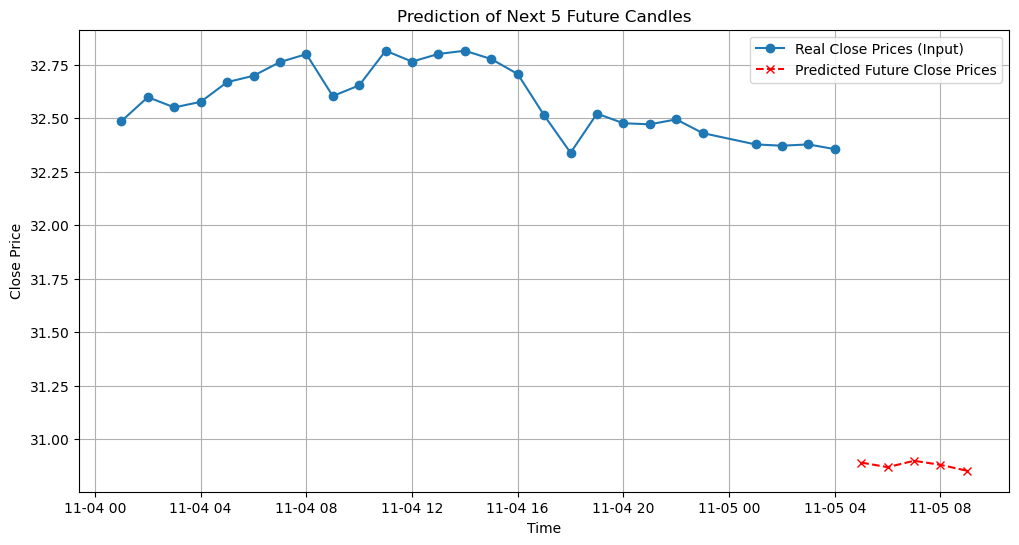

In [15]:
# --- New Code Starts Here ---

import matplotlib.pyplot as plt

# Load recent real candles for prediction
recent_candles = pd.read_csv("../datasets/new-data-for-test/rows-60-from-20241031.csv", sep='\t')

# Combine <DATE> and <TIME> into single datetime index
recent_candles['DATETIME'] = pd.to_datetime(recent_candles['<DATE>'] + ' ' + recent_candles['<TIME>'])
recent_candles.set_index('DATETIME', inplace=True)
recent_candles.drop(columns=['<DATE>', '<TIME>'], inplace=True)


# Compute TA indicators and append to dataframe.
# e.g. RSI, ATR, MACD Histogram
recent_candles['rsi'] = talib.RSI(recent_candles['<CLOSE>'], timeperiod=14)
macd, macd_sig, macd_hist = talib.MACD(recent_candles['<CLOSE>'], fastperiod=12, slowperiod=26, signalperiod=9)
recent_candles['macd_hist'] = macd_hist
recent_candles['atr'] = talib.ATR(recent_candles['<HIGH>'], recent_candles['<LOW>'], recent_candles['<CLOSE>'], timeperiod=14)
recent_candles.dropna(inplace=True)


# Select the latest SEQUENCE_LENGTH candles
input_candles = recent_candles.tail(SEQUENCE_LENGTH)

# Scale the input using the same scaler from training
input_features = input_candles[feature_cols]
input_scaled = scaler.transform(input_features)
input_scaled = np.expand_dims(input_scaled, axis=0)  # (1, 30, 4)

# Predict future prices
predicted_future_prices = model.predict(input_scaled)[0]  # shape = (PREDICT_HORIZON,)
print("Predicted Future Prices:", predicted_future_prices)

# Prepare for plotting
# Get the last real CLOSE price
last_real_close = input_candles['<CLOSE>'].iloc[-1]
# Build X axis (time)
real_times = input_candles.index
future_times = pd.date_range(start=real_times[-1] + pd.Timedelta(hours=1), periods=PREDICT_HORIZON, freq='h')

# Plot real CLOSE prices
plt.figure(figsize=(12,6))
plt.plot(real_times, input_candles['<CLOSE>'], label='Real Close Prices (Input)', marker='o')

# Plot predicted future prices
plt.plot(future_times, predicted_future_prices, label='Predicted Future Close Prices', marker='x', linestyle='--', color='red')

# Decorations
plt.title(f"Prediction of Next {PREDICT_HORIZON} Future Candles")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()
